## San Dimas Plant Process Analysis

In [2]:
# Necessary libraries for analysis

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import warnings
 
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore") 

# integrated developement enviroment

In [16]:
# Import excel file (must be a relational table).
data = pd.read_excel(r"San Dimas.xlsx",sheet_name="DBBP")


In [17]:
# Create new variables (year, month, year by mont and year by q) using 'date' time variable.
# Date categorical variables
data['year'] = pd.DatetimeIndex(data['Date']).year.astype(str)
data['quarter'] = pd.DatetimeIndex(data['Date']).quarter.astype(str)
#data['quarter'] = pd.DatetimeIndex(data['Date']).dt.to_period('Q').astype(str)
data['month'] = pd.DatetimeIndex(data['Date']).month
data['ym'] = data.year.astype(str).str.cat(data.month.astype(str), sep='M')

# Operation variables
data['Grinding operation (%)'] = ((data['Operation time BM1 (h)']+data['Operation time BM2 (h)']+data['Operation time BM3 (h)'])/72)*100

# Disolution (response) variables
data['Ag dissolution (%)'] =  ((data['Ag head grade calculated (g/t)']-data['Ag tailings grade (g/t)'])/data['Ag head grade calculated (g/t)'])*100
data['Au dissolution (%)'] =  ((data['Au head grade calculated (g/t)']-data['Au tailings grade (g/t)'])/data['Au head grade calculated (g/t)'])*100

data['Ag/Au ratio'] =  data['Ag head grade calculated (g/t)']/data['Au head grade calculated (g/t)']
data['M3/t'] =  data['MC pumping (m3)']/data['Tonnage (t)']

data['Ag feed content (kg)'] = (data['Ag head grade calculated (g/t)']*data['Tonnage (t)'])/1000
data['Au feed content (kg)'] = (data['Au head grade calculated (g/t)']*data['Tonnage (t)'])/1000

At this point data = original dataset with new variables included (disolution, year, etc.)

In [19]:
# Splits by year and get 2022 dataframe of interest called d22.
# Data per year.
d0 = data.copy() # Create a copy of original (data) dataset
d21 = d0.groupby('year').get_group("2021") # create a dataframe of 2022 (d22) exctracted from original dataset (data)
d22 = d0.groupby('year').get_group("2022") # create a dataframe of 2022 (d22) exctracted from original dataset (data)

# Data per half.
d21q1 = d21.groupby('quarter').get_group("1") # Create a df of q1 of 2021
d21q2 = d21.groupby('quarter').get_group("2") # Create a df of q2 of 2021
d21h1 = pd.concat([d21q1,d21q2],axis=0) # Concatenate q1 and q2 of 2021 to create h1 dataframe

d21q3 = d21.groupby('quarter').get_group("3") 
d21q4 = d21.groupby('quarter').get_group("4") 
d21h2 = pd.concat([d21q3,d21q4],axis=0)

d22q1 = d22.groupby('quarter').get_group("1") 
d22q2 = d22.groupby('quarter').get_group("2") 
d22h1 = pd.concat([d22q1,d22q1],axis=0)

#d22q3 = d22.groupby('quarter').get_group("3")
#d22q4 = d22.groupby('quarter').get_group("4")
#d22h2 = pd.concat([d22q3,d22q4],axis=0)


d2204 = d22.groupby('month').get_group(4) # Create a dataframe of month 4 of year 2022
d2205 = d22.groupby('month').get_group(5) # Create a dataframe of month 4 of year 2022
d2206 = d22.groupby('month').get_group(6) # Create a dataframe of month 4 of year 2022



##### Datasets

- d0 is a copy of orignal dataset with new variables (data)
- d22 is a dataframe of 2022 exctracted from original dataset (data of 2022)
- d2204 is a copy dataframe of month 04 from year 2022 (data of April 2022)


Slect Variables (columns)

In [48]:
all_in = data.columns.to_list()


In [49]:
# Regression variables

xy_vars = ['Tonnage (t)',
    'F80 BM (μm)',
    'Agitation time (h)',
    'P80 BFD (μm)',
    'Agitation pH',
    'Agitation cyanide (ppm)',
    'Ag head grade calculated (g/t)',
    'Cu head grade (%)',
    'Ag dissolution (%)',
    'Ag recovery (%)']#.astype('float')


In [51]:
# And then create a dataframe containing interest variables from specific dataset (d, d22 or d2204)
dataframe = pd.DataFrame(d2206[xy_vars])#.astype('float')
dataframe.head()

,Tonnage (t),F80 BM (μm),Agitation time (h),P80 BFD (μm),Agitation pH,Agitation cyanide (ppm),Ag head grade calculated (g/t),Cu head grade (%),Ag dissolution (%),Ag recovery (%)
1612,2393.0,8764.449083,88.04,95.738329,11.1,2204.000000,281.399176,NaN,96.055426,95.467353
1613,2450.0,8906.646862,87.07,79.214036,11.2,2127.777778,223.133515,NaN,95.249481,94.341134
1614,2486.0,10267.133450,124.44,88.136913,11.2,2156.250000,230.491768,NaN,95.314366,94.517987
1615,2468.0,8804.223048,86.05,93.788269,11.1,2073.958333,230.737527,NaN,95.406036,94.802780
1616,2464.0,8764.274000,84.90,97.730562,11.1,2011.111111,208.903476,NaN,95.069493,94.434914


Acronyms

In [52]:
df_by_year_and_mont = d0.groupby('ym')
df_by_year_and_mont[xy_vars].mean()

,Tonnage (t),F80 BM (μm),Agitation time (h),P80 BFD (μm),Agitation pH,Agitation cyanide (ppm),Ag head grade calculated (g/t),Cu head grade (%),Ag dissolution (%),Ag recovery (%)
ym,,,,,,,,,,
2018M1,1591.222222,NaN,142.203385,NaN,NaN,NaN,298.209538,NaN,95.262043,95.280368
2018M10,2302.423077,7968.804937,100.546930,NaN,NaN,NaN,244.421167,NaN,94.694752,94.647325
2018M11,2370.360000,8555.464609,106.497575,NaN,NaN,NaN,248.868212,NaN,93.898027,93.763465
2018M12,2291.777778,9207.067208,98.633389,NaN,11.140741,1420.943827,313.839501,NaN,92.826838,92.742479
2018M2,1858.666667,NaN,140.523958,NaN,NaN,NaN,437.230848,NaN,97.081949,97.014173
2018M3,1898.806452,NaN,113.124981,NaN,NaN,NaN,405.669403,NaN,92.075069,92.009478
2018M4,1950.111111,NaN,123.928741,NaN,NaN,NaN,304.207728,NaN,93.451231,93.375085
2018M5,1815.960000,NaN,17.568528,NaN,NaN,NaN,392.553184,NaN,93.014415,95.095358
2018M6,2151.240000,8336.873232,4.772881,NaN,NaN,NaN,217.755616,NaN,94.993860,95.511127


In [53]:
# Declare Acronyms "nicknames"

hau = "Au head grade calculated (g/t)"
hag = "Ag head grade calculated (g/t)"

tau = "Au tailings grade (g/t)"
tag = "Ag tailings grade (g/t)"

tags = 'Ag tailings solution (ppm)'
taus = 'Au tailings solution (ppm)'

rau = "Au recovery (%)"
rag = "Ag recovery (%)"

dau = "Au dissolution (%)"
dag = "Ag dissolution (%)"

agit = 'Agitation time (h)'
cn = 'Agitation cyanide (ppm)'
ton = 'Tonnage (t)'
mct = 'M3/t'
p80 = 'P80 BFD (μm)'

jess = 'Haulage Jessica (tpd)'
reg  = 'Haulage area Sta. Regina (tpd)'

cag = 'Ag feed content (kg)'
cau = 'Au feed content (kg)'

## Missing data treatment

https://pypi.org/project/miceforest/

In [29]:
df = dataframe.copy()

Libraries needed

In [30]:
import miceforest as mf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Select dataset

Miceforest Multiple Imputation

In [31]:
# Create kernel. 
kernel = mf.ImputationKernel(
  df,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Printing the kernel will show you some high level information.
print(kernel)

# Select dataset with imputated data
dfk = kernel.complete_data(0)

              Class: ImputationKernel
           Datasets: 4
         Iterations: 2
  Imputed Variables: 10
save_all_iterations: True


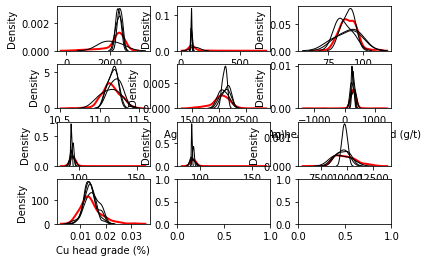

In [13]:
# Distribution of imputed values 

kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)

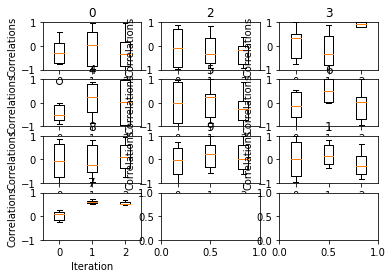

In [14]:
# Convergence of correlation 

kernel.plot_correlations()

AxesSubplot(0.125,0.125;0.62x0.755)


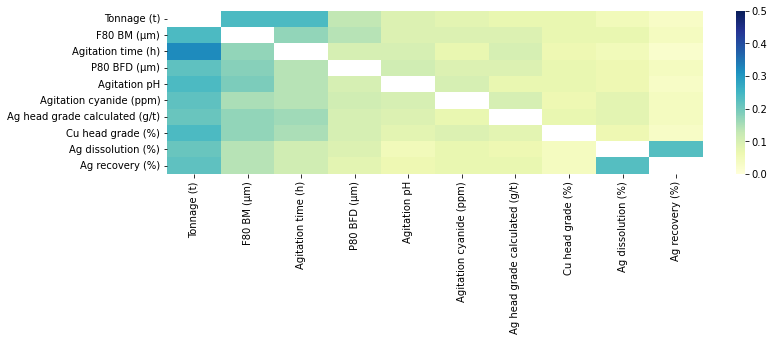

In [15]:
# Variable impotance in missing data calculation

plt.figure(figsize=(12,3))
kernel.plot_feature_importance(dataset=0, annot=False,cmap="YlGnBu",vmin=0, vmax=0.5)

<Figure size 720x360 with 0 Axes>

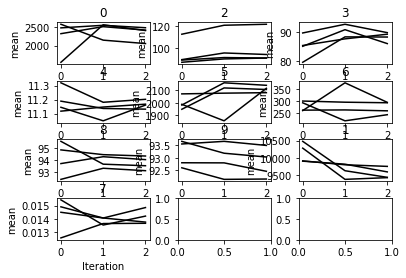

In [16]:
# Mean convergence

plt.figure(figsize=(10,5))
kernel.plot_mean_convergence(wspace=0.3, hspace=0.4)

In [17]:
dfk.describe()

,Tonnage (t),F80 BM (μm),Agitation time (h),P80 BFD (μm),Agitation pH,Agitation cyanide (ppm),Ag head grade calculated (g/t),Cu head grade (%),Ag dissolution (%),Ag recovery (%)
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,2254.796610,9846.498232,111.078651,89.084217,11.143750,2035.137358,278.135908,0.014094,94.786827,94.061606
std,491.881087,1005.719946,62.596920,6.229784,0.120320,175.528861,169.633640,0.003783,5.041789,5.592684
min,289.000000,6799.211225,77.300000,69.919624,10.635000,1491.854000,-1200.702232,0.007000,89.320037,88.384503
25%,2253.000000,8942.731552,88.373515,84.758952,11.090000,1964.583333,230.491768,0.012000,93.241658,92.182286
50%,2380.000000,9770.059803,94.532410,88.614888,11.135000,2050.000000,289.100330,0.013333,94.384260,93.601253
75%,2546.000000,10528.932596,102.513960,93.500000,11.213333,2150.000000,332.468711,0.015667,95.406036,94.736476
max,2772.000000,12754.274771,651.877589,110.941160,11.452500,2698.200000,1221.449457,0.031000,152.271153,157.749896


In [32]:
df = dfk.copy()

## Correlation

##### Select dataset

In [54]:
df = dfk.copy()

In [55]:
df = dataframe.copy()

##### Heatmap

<AxesSubplot:>

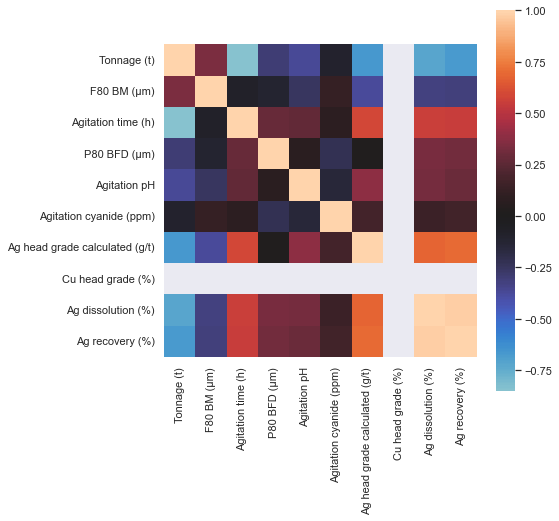

In [56]:
# Correlation table and heatmap
dfcorr = df.corr()

# Heatmap

f, ax = plt.subplots(figsize=(7,7))

sns.heatmap(dfcorr,vmax=1,square=True,center=0)


##### Most correlated variables

Select response

In [57]:
y = dag
k = 20

The following table shows the strongest positive and negative correlations with Ag dissolution (%)


,Variable,r,p-Value
0,Tonnage (t),-0.714,0.000
5,Agitation time (h),0.559,0.001


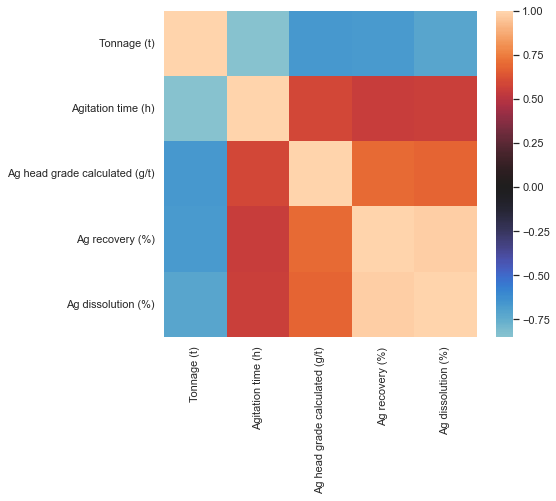

In [58]:
# The Definitive Paired Crrelation Table with p-Value and Heatmap

# Calculate correlation matrix of original dataframe
dfcorr = df.corr()

# Select main variable and k for n interest correlations
#y = y # because we declared it be4
#k = k #because we declared it be4

# Create a data frame of n largest POSITIVE correlations
s = dfcorr.unstack()
sp = s.sort_values(kind="quicksort")
spn = pd.DataFrame(sp[y])

# Concatenate data frames to create a table
frames = [spn]
xcorr =  round(pd.concat(frames),3)

# Significance of Correlations
x = xcorr.index
pval = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x,y)[1]) - np.eye(*pval.shape)
pval = round((pval).unstack(),3)
pval = pval.sort_values(kind="quicksort")
pval = pval[y]
pval = pd.DataFrame(pval)
pval = pval.T
pval = pval[x].T

#Create a data frame that contains variable names using positive and negative correlations table
corrsig = pd.DataFrame(xcorr.index)

# Reset indexes of correlation and p value tables (dataframes)
xcorr.reset_index(inplace=True, drop=True)
pval.reset_index(inplace=True, drop=True)

# Concatenate tables
pairs = pd.DataFrame(pd.concat([corrsig,xcorr,pval],axis=1))
pairs.drop_duplicates()

# Rename column names
pairs = pairs.set_axis(['Variable', 'r', 'p-Value'], axis=1, inplace=False)

# Print table and heatmap
print("The following table shows the strongest positive and negative correlations with", y)
pVal = pairs[pairs['p-Value'] < 0.05]
rVal =  pVal[pVal['r'] < -0.1]
rVal = rVal.drop_duplicates()
qVal =  pVal[pVal['r'] > 0.1]
qVal = qVal.drop_duplicates()

#pd.concat([rVal,qVal],axis=0)
rtable = pd.concat([rVal,qVal],axis=0)

# Heatmap of higher correlations
#Create a list of higher positive and negative correlations to create a dataframe that contains these variables
list = rtable['Variable'].tolist()
d = df[list]

# Calculate correlation matrix and create heatmap
dcorr = d.corr()
f, ax = plt.subplots(figsize=(7,6))
#heat = sns.heatmap(dcorr,vmax=1,square=True,center=0)
heat = sns.heatmap(dcorr,vmax=1,square=False,center=0)

# Exclude correlated variables that contain 'Ag ' (lrtable for linear regression table).
# lrtable Variable values are ment to be used in a linear regression
# Note the use of '~' that is the 'ivert operator'

lrtable = rtable[~rtable.Variable.str.contains('Ag ')] 
lrtable


In [43]:
corr_vars = lrtable['Variable'].to_list()

#### Variation analysis using Boxplot

These is the Boxplots of Ag dissolution (%)


,Ag dissolution (%),Ag dissolution (%)
ym,,
2022M1,93.604140,4.299880
2022M2,94.354178,1.332928
2022M3,93.835220,0.966452
2022M4,93.748437,2.256275
2022M5,94.686134,5.232467
2022M6,95.328115,0.758651


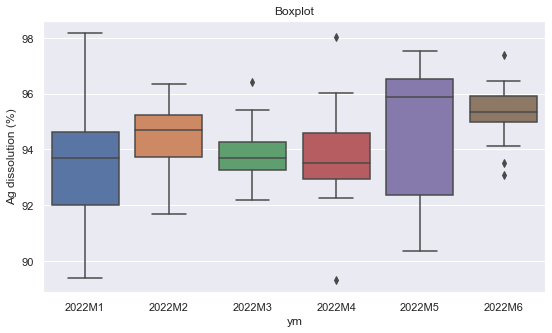

In [40]:
# Boxplot of y variable

import seaborn as sns
df = dfk.copy()
df = df[df[y] < 100]
# Person correlation coef and sig. 
d = pd.DataFrame(df[dag])
# In case of hue need.
d['ym'] = data['ym']
h = 'ym'
#d['year'] = data['year']
#d['quarter'] = data['quarter']


var = 0
x = xy_vars[var]

#Eliminar filas con algún valor 0
     

#Crear gráfica
sns.set(rc={'figure.figsize':(9,5)})
plt.figure()
sns.boxplot(data=d, x=h, y=dag)
#sns.scatterplot(data=d,x=x, y=y, hue="year")
#sns.lmplot(data=d,x=x, y=y,hue="year")
plt.title("Boxplot")
var = var + 1

print("These is the Boxplots of", dag)

dfkmean = d.groupby('ym')
pd.concat([dfkmean.mean(),dfkmean.var()],axis=1)

These are the Boxplots of most correlated variables with Ag dissolution (%)


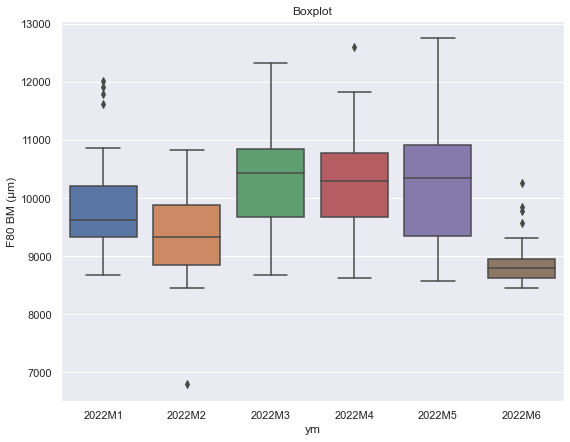

In [44]:
# Boxplot of the x variables correlated with y variable

import seaborn as sns
df = dfk
df = df[df['Cu head grade (%)'] < 1]
var = 0
x = corr_vars[var]


for x in corr_vars:
    # Person correlation coef and sig. 
    d = df[corr_vars]
    # In case of hue need.
    d['ym'] = data['ym']
    h = 'ym'
    #d['year'] = data['year']
    #d['quarter'] = data['quarter']
    
    #Eliminar filas con algún valor 0
    d= d[d[x] != 00]
       
    #Crear gráfica
    sns.set(rc={'figure.figsize':(9,7)})
    plt.figure()
    sns.boxplot(data=d,x=h, y=x)
    #sns.scatterplot(data=d,x=x, y=y, hue="year")
    #sns.lmplot(data=d,x=x, y=y,hue="year")
    plt.title("Boxplot")
    var = var + 1
   

print("These are the Boxplots of most correlated variables with", y)


These are the Boxplots of most correlated variables with Ag dissolution (%)


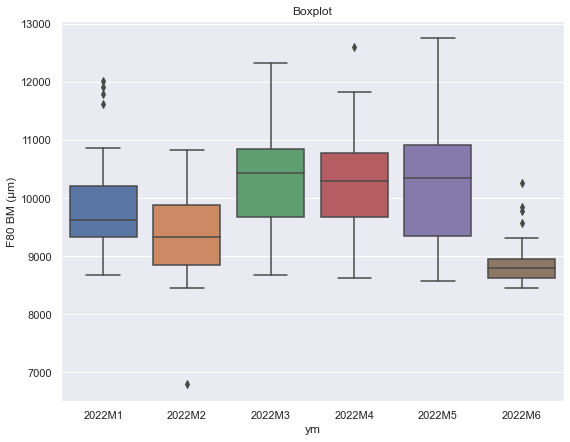

In [45]:
# Boxplot of the x variables correlated with y variable

import seaborn as sns
df = dfk

var = 0
x = corr_vars[var]


for x in corr_vars:
    # Person correlation coef and sig. 
    d = df[corr_vars]
    # In case of hue need.
    d['ym'] = data['ym']
    h = 'ym'
    #d['year'] = data['year']
    #d['quarter'] = data['quarter']
    
    #Eliminar filas con algún valor 0
    d= d[d[x] != 00]
       
    #Crear gráfica
    sns.set(rc={'figure.figsize':(9,7)})
    plt.figure()
    sns.boxplot(data=d,x=h, y=x)
    #sns.scatterplot(data=d,x=x, y=y, hue="year")
    #sns.lmplot(data=d,x=x, y=y,hue="year")
    plt.title("Boxplot")
    var = var + 1
   

print("These are the Boxplots of most correlated variables with", dag)


In [ ]:
d2205[x_vars].std()

Grinding operation (%)      8.079308
Tonnage (t)               383.781531
P80 BFD (μm)                7.954803
Agitation time (h)          5.001172
dtype: float64

In [ ]:
x_vars = lrtable['Variable'].to_list()
x_vars

['Grinding operation (%)', 'Tonnage (t)', 'P80 BFD (μm)', 'Agitation time (h)']

#### Scatterplot of more correlated variables

Crossed validation 
Ridget regression

Lasso Regression
https://machinelearningmastery.com/lasso-regression-with-python/

Lasso Regression Validation
https://machinelearningmastery.com/k-fold-cross-validation/

Used to discrimine autocorrelated variables



In [59]:
y = dag
x_vars = lrtable['Variable'].to_list()

Correlation and p-Value are: (-0.7137958070043092, 9.479349076804248e-06)
Correlation and p-Value are: (0.5587811968417996, 0.0013295438125940583)

 These are the scatterplots of most correlated variables with Ag dissolution (%) 



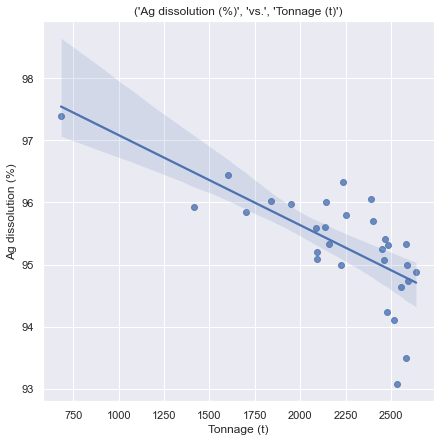

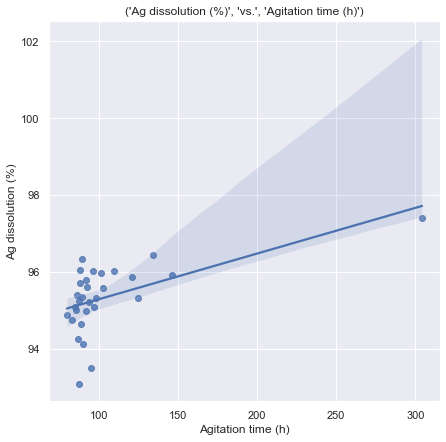

In [60]:
# Scatterplot and correlation x variables vs. y variable

var = 0
y = dag
x_vars = lrtable['Variable'].to_list()
x = x_vars[var]


for x in x_vars:
    # Person correlation coef and sig. 
    d = pd.concat([df[x],df[y]],axis=1)
    print("Correlation and p-Value are:",pearsonr(d[x],d[y]))
    
    # In case of hue need.
    #d['ym'] = data['ym']
    #d['year'] = data['year']
    #d['quarter'] = data['quarter']
    
    # Delete rows with oversize or 0
    d= d[d[x] != 00]
    d= d[d[y] < 100]
    
    #Crear gráfica
    sns.set(rc={'figure.figsize':(7,7)})
    plt.figure()
    sns.regplot(data=d,x=x, y=y)
    #sns.scatterplot(data=d,x=x, y=y, hue="year")
    #sns.lmplot(data=d,x=x, y=y,hue="year")
    title = y,"vs.",x
    plt.title(str(title))
    plt.ylabel(y)
    plt.xlabel(x)
    
    var = var + 1

print("\n These are the scatterplots of most correlated variables with", y, "\n")

## Stepwise Linear Regression

In [ ]:
df = dfk #Which is our data frame WITH imputed values

In [ ]:
y = df[dag]
x_vars = lrtable['Variable'].to_list() #lrtable is linear regression table wich comes from rtable
x_vars


['Grinding operation (%)', 'Tonnage (t)', 'P80 BFD (μm)', 'Agitation time (h)']

In [ ]:
## creating function to get model statistics

import numpy as np
import statsmodels.api as sm
def get_stats():
    x = df[x_vars]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

x = df[x_vars]
results = sm.OLS(y, x).fit()
coefficients = results.params.to_list() # El método .params de la función sm.OLS devuelve los coeficientes



                                 OLS Regression Results                                
Dep. Variable:     Ag dissolution (%)   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.542e+04
Date:                Sat, 04 Jun 2022   Prob (F-statistic):                   4.88e-174
Time:                        14:51:38   Log-Likelihood:                         -389.08
No. Observations:                 135   AIC:                                      786.2
Df Residuals:                     131   BIC:                                      797.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [ ]:
# Remove less signifficant predictor from model

#x_columns.remove("Tonnage (t)")
#get_stats()

In [ ]:
# Print regression variables and their coefficients
print("these are the variables: \n",x_vars,"\n and these are their coefficientes: \n",coefficients)

# Calculate regression variables means in last month
tbdm = data.groupby("ym").get_group('2022M4')
print("\n Means of x variables in present month are:\n",tbdm[x_vars].mean(),
    "\n meanwhile", dag, "is :",round(tbdm[dag].mean(),2))


these are the variables: 
 ['Grinding operation (%)', 'Tonnage (t)', 'P80 BFD (μm)', 'Agitation time (h)'] 
 and these are their coefficientes: 
 [0.1084534462878354, 0.0017018664653321216, 0.4161383929230839, 0.44676678391123203]

 Means of x variables in present month are:
 Grinding operation (%)      90.012050
Tonnage (t)               2284.400000
P80 BFD (μm)                89.028226
Agitation time (h)          89.001972
dtype: float64 
 meanwhile Ag dissolution (%) is : 93.75


In [ ]:
# Input values of x variables to predict y using regression coefficients.

# Convert x_vars in a string (str)
x0 = str(x_vars[0])
x1 = str(x_vars[1])
x2 = str(x_vars[2])
x3 = str(x_vars[3])

# Use x_vars str to indicate input
x_var0 = float(input(x0))
x_var1 = float(input(x1))
x_var2 = float(input(x2))
#x_var3 = float(input(x3))

# Calculate 'y' using inputs and regression coef
y_pred = coefficients[0]*x_var0+coefficients[1]*x_var1+coefficients[2]*x_var2
print(dag, "prediction is:", round(y_pred,2),", and actual", dag, "is:",round(tbdm[dag].mean()),2)

ValueError: could not convert string to float: ''

##### Model creation and y prediction

In [ ]:
df = dfk

In [ ]:
# Creating a linear model and prediction with 'sklean'

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[df != dag], df[dag], random_state=0)


linear_model = LinearRegression() # Asign LinearRegression() function to the name linear_model
linear_model.fit(X_train, y_train) # 
y_pred = linear_model.predict(X_test)
print("Prediction for Ag dissolution is ", y_pred.mean())


Prediction for Ag dissolution is  95.15682277555341


##### ML Model Prediction

In [ ]:
df = dfk

In [ ]:
# Creating a linear model and prediction with 'sklean'

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[x_vars], df[dag], random_state=0)


linear_model = LinearRegression() # Asign LinearRegression() function to the name linear_model
linear_model.fit(X_train, y_train) # 
y_pred = linear_model.predict(X_test)
print("Training prediction for Ag dissolution is ", round(y_pred.mean(),2))

Training prediction for Ag dissolution is  95.11


In [ ]:
x_vars

['F80 BM (μm)', 'P80 BFD (μm)', 'Tonnage (t)', 'Cu head grade (%)']

In [ ]:
x3 = str(x_vars[3])

In [ ]:
# Predict Ag dissolution using Plant Parameters 

# Use x_vars str to indicate input
x_var0 = float(input(x0))
x_var1 = float(input(x1))
x_var2 = float(input(x2))
x_var3 = float(input(x3))

x_plant = {
    x0:[x_var0],
    x1:[x_var1],
    x2:[x_var2],
    x3:[x_var3],
    }

x_plant = pd.DataFrame(x_plant)
y_pred = linear_model.predict(x_plant)
print("Prediction for Ag dissolution is ", y_pred)


Prediction for Ag dissolution is  [94.43601503]


## Lasso Regression


In [ ]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

In [ ]:
# define model
model = Lasso(alpha=1.0)

In [ ]:
# load the dataset
df = dfk
df = df.values
X, y = df[:, :-1], df[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 1.179 (0.205)


In [ ]:
# Import excel file (must be a relational table).
data = pd.read_excel(r"San Dimas xy.xlsx",sheet_name="DATA")

# Create new variables (year, month, year by mont and year by q) using 'date' time variable.
# Date categorical variables
data['year'] = pd.DatetimeIndex(data['Date']).year.astype(str)
data['quarter'] = pd.DatetimeIndex(data['Date']).quarter.astype(str)
#data['quarter'] = pd.DatetimeIndex(data['Date']).dt.to_period('Q').astype(str)
data['month'] = pd.DatetimeIndex(data['Date']).month
data['ym'] = data.year.astype(str).str.cat(data.month.astype(str), sep='M')

# Operation variables
data['Ag feed content (kg)'] = (data['Ag head grade calculated (g/t)']*data['Tonnage (t)'])/1000
data['Au feed content (kg)'] = (data['Au head grade calculated (g/t)']*data['Tonnage (t)'])/1000
data['Grinding operation (%)'] = ((data['Operation time BM1 (h)']+data['Operation time BM2 (h)']+data['Operation time BM3 (h)'])/72)*100
data['Ag/Au ratio'] =  data['Ag head grade calculated (g/t)']/data['Au head grade calculated (g/t)']
data['M3/t'] =  data['MC pumping (m3)']/data['Tonnage (t)']

# Disolution (response) variables
data['Ag dissolution (%)'] =  ((data['Ag head grade calculated (g/t)']-data['Ag tailings grade (g/t)'])/data['Ag head grade calculated (g/t)'])*100
data['Au dissolution (%)'] =  ((data['Au head grade calculated (g/t)']-data['Au tailings grade (g/t)'])/data['Au head grade calculated (g/t)'])*100

nrow = data[xy_vars]
nrow = nrow.drop(['Ag dissolution (%)'],axis=1)


In [ ]:
# make a prediction with a lasso regression model on the dataset
from pandas import read_csv
from sklearn.linear_model import Lasso

# load the dataset
df = dfk
df = df.values
X, y = df[:, :-1], df[:, -1]
# define model
model = Lasso(alpha=1.0)
# fit model
model.fit(X, y)
# define new data
row = nrow.values
# make a prediction
yhat = model.predict(row)
# summarize prediction
print('Predicted: %.3f' % yhat)


Predicted: 94.688


## KMeans clustering

In [61]:
x_vars = lrtable['Variable'].to_list()
k_vars = x_vars.copy()
k_vars.append(dag)
k_vars


['Tonnage (t)', 'Agitation time (h)', 'Ag dissolution (%)']

In [62]:
#Select variables and create an array of lists for each i using a for loop

# Import data
df = dfk
df['Date'] = d22['Date']
df.set_index('Date')

# Select variables (columns)
df = df[k_vars]

# Delete "uncomplete" rows
df = df.dropna()

# For loop to select and append values to array
n = 0
x=[]
a= df.iloc[n]

for i in df.index:
    a= df.iloc[n]
    x.append(a.values.tolist())
    n = n + 1

In [63]:
xhat = df[k_vars].values


Text(0, 0.5, 'WCSS')

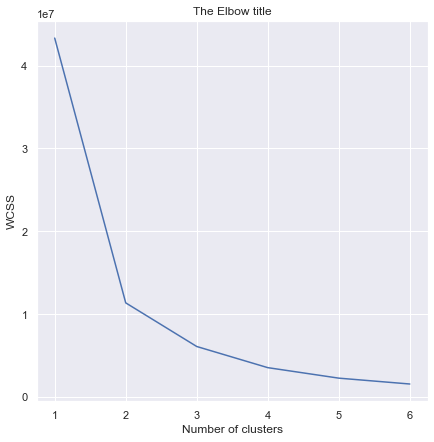

In [64]:
# Determine number of clusters
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,7):
    kclust = KMeans(i)
    kclust.fit(xhat)
    wcss_iter = kclust.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [65]:
kn = 2

In [66]:
# Calculate Clusters

from sklearn.cluster import KMeans

kclust = KMeans(n_clusters=kn).fit(xhat)
kclust.fit(xhat)
clust_id = kclust.fit_predict(xhat)
clust_id

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0])

In [67]:
df.columns

Index(['Tonnage (t)', 'Agitation time (h)', 'Ag dissolution (%)'], dtype='object')

In [68]:
df_clust = df.copy()
df_clust['Clust'] = clust_id
df_clust.groupby('Clust').mean()

,Tonnage (t),Agitation time (h),Ag dissolution (%)
Clust,,,
0,2415.198718,93.914248,94.714520
1,1203.720000,216.693037,95.424156


In [69]:
df_clust.columns

Index(['Tonnage (t)', 'Agitation time (h)', 'Ag dissolution (%)', 'Clust'], dtype='object')

In [73]:
df_clust.Clust.value_counts()

0    156
1     25
Name: Clust, dtype: int64

In [78]:
import matplotlib as mt

In [75]:
k_vars[2]

'Ag dissolution (%)'

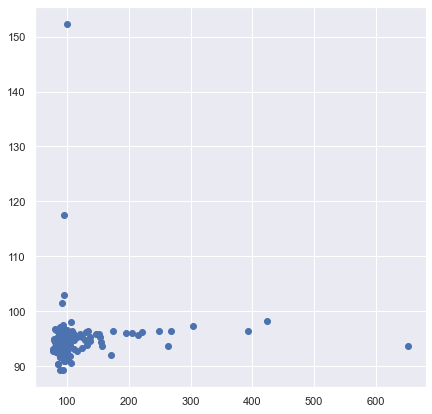

In [79]:
#Crear gráfica
x = df_clust[k_vars[1]]
y = df_clust[dag]
# Graph
mt.pyplot.scatter(x,y)

In [84]:
df_clust.mean(axis=0)

Tonnage (t)           2247.867403
Agitation time (h)     110.872644
Ag dissolution (%)      94.812536
Clust                    0.138122
dtype: float64

## PCA

In [85]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# Configuración warnings
# ==============================================================================
import warnings

In [86]:
pd.DataFrame(df.mean(axis=0))

,0
Tonnage (t),2247.867403
Agitation time (h),110.872644
Ag dissolution (%),94.812536


In [87]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df)

# Se extrae el modelo entrenado del pipeline
pca_model = pca_pipe.named_steps['pca']

In [88]:
df = df.loc[df.index.drop_duplicates()]

In [91]:
loadings_pca = pd.DataFrame(
    data    = pca_model.components_,
    columns = df.columns,
    index   = ['PC1', 'PC2', 'PC3'])
    
loadings_pca.T

,PC1,PC2,PC3
Tonnage (t),-0.703581,0.064458,0.707685
Agitation time (h),0.702244,-0.089339,0.706309
Ag dissolution (%),0.108751,0.993913,0.017592


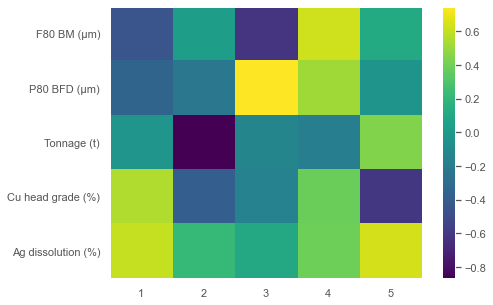

In [ ]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
components = pca_model.components_
plt.imshow(components.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(df.columns)), df.columns)
plt.xticks(range(len(df.columns)), np.arange(pca_model.n_components_) + 1)
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.30278576 0.22201401 0.19755197 0.15456541 0.12308285]


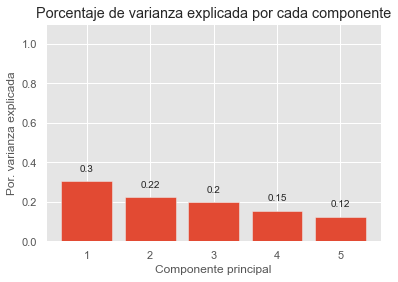

In [ ]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca_model.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_model.n_components_) + 1,
    height = pca_model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, pca_model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.30278576 0.52479977 0.72235174 0.87691715 1.        ]


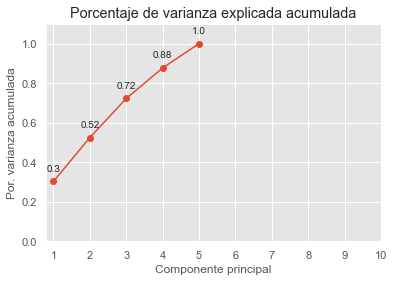

In [ ]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = pca_model.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(df.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

## PCA - Regression

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
df = dfk

In [ ]:
X = df.drop(columns=dag)
y = df[dag]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [ ]:
pipe_modelado.set_params

<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 1.1988575553251606


In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(3)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
2,4,-1.881888,0.407821,-1.878790,0.095448
0,1,-1.890549,0.390730,-1.928120,0.108185
1,2,-1.909889,0.397134,-1.916583,0.108746


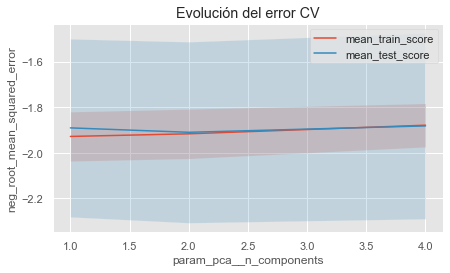

In [ ]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 4} : -1.8818878517476219 neg_root_mean_squared_error


In [ ]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=4), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('linearregression', LinearRegression())])

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 1.1988575553251606


In [ ]:
loadings_pca[0:4]

,F80 BM (μm),P80 BFD (μm),Tonnage (t),Cu head grade (%),Ag dissolution (%)
PC1,-0.442648,-0.348186,-0.026529,0.557991,0.60891
PC2,0.040043,-0.225615,-0.867877,-0.384823,0.21493
PC3,-0.624105,0.748269,-0.130961,-0.149421,0.10540
PC4,0.631168,0.516528,-0.178004,0.384431,0.39415
